# What makes difference between a job title - DA / DS

![kaggle_survey_image.png](attachment:kaggle_survey_image.png)

# 0. Introduction 
### Coding and Data Analysis

These are the most trending words around a world and it has taken over the country. 
 
Many education-tech companies in Korea have started launching data-related courses and programs and this trend is still ongoing. Our team is also one of them who have a different background and are actively seeking a data-related job. However, it is pretty hard to decide which job title or role would fit due to unsettled definitions or roles among Data Scientist (DS), Data Anaylst(DA), and Data Engineer(DE) across industries.

As a job seeker, the team would like to see the exact role or necessary skills to be one of them (DS, DA, DE, etc.).

This notebook will focus on questions that job seekers or beginners like us would be curious about data-related industry and we hope to gain much clearer comprehensive veiw of state of data-related jobs to be prepared.


Let's dive into the survey!

# Libraries

In [1]:
## 삭제
!pip install squarify
!pip install pywaffle
!pip install --upgrade plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(font_scale = 2.5) # Setting up font size as default

import squarify           # Treemap
plt.style.use('fivethirtyeight')
from pywaffle import Waffle

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# plotly
import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# 1. Import Dataset

In [3]:
response = pd.read_csv('kaggle_survey_2021_responses.csv', encoding = 'ISO-8859-1')
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

In [4]:
# Save Questions as a list and fill missing values into ''
question_list = response.iloc[0,].values
response = response.iloc[1:,:].reset_index(drop = True)
response.fillna('', inplace = True)
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,910,50-54,Man,India,Bachelorâs degree,Other,5-10 years,Python,R,,,,,,,,,,,,Python,,,,,,,,,Vim / Emacs,,,,,,Colab Notebooks,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,784,50-54,Man,Indonesia,Masterâs degree,Program/Project Manager,20+ years,,,SQL,C,C++,Java,,,,,,,,Python,,,,,,,Notepad++,,,,Jupyter Notebook,,,Kaggle Notebooks,Colab Notebooks,,,,,...,,,Qlik,,,,,,,,,,,,"Automated model selection (e.g. auto-sklearn, ...",,,,,,Google Cloud AutoML,,,,,,,,,,,,,,,,,,None,
2,924,22-24,Man,Pakistan,Masterâs degree,Software Engineer,1-3 years,Python,,,,C++,Java,,,,,,,,Python,,,,,PyCharm,,,,,,Jupyter Notebook,,Other,Kaggle Notebooks,,,,,,...,,,,,,,,,,,,,,,"Automated model selection (e.g. auto-sklearn, ...",,,,,,,,,DataRobot AutoML,,,,,,,,,TensorBoard,,,,,,,
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,,,,,,,,,,,,,Python,,,,,,Spyder,,,,,Jupyter Notebook,,,,Colab Notebooks,,,,,...,,,,,,,,,,,None,,,,,,,,None,,,,,,,,,,,,,,,,,,,,None,
4,781,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,,,C,,,,,,,MATLAB,,,Python,,,,,,Spyder,,,,MATLAB,Jupyter Notebook,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


# 2. Feature Engineering and Data Wrangling

## 2.1 Combining all relevant features
   
At the first glance, the team recognize that some features come from a single multiple-choice question. Thus, we decide to combine all relavent features into one feature.


In [5]:
def total_answer(df, column):
    """
    A function to combine all relevant features coming from a multiple-choice question
    column : column name
    """ 
    # Extract all relevant columns corresponding to 'column'
    col = df.columns[df.columns.str.contains(column)]
    tmp = df[col]
    # Fill missing values with empty space ''
    tmp = tmp.fillna('')
    
    # Add comma(,) between answers
    total = tmp.apply(','.join, axis=1)

    # Remove unnecessary comma(,)
    import re
    ls = []
    for i in total:
        ls.append(re.sub(',{2,}', ',', i).strip(',')) ## Replace double commas into one

    # Delete the rest of columns that are already used
    df.drop(col, axis=1, inplace=True)

    # Store the combined answers into a column
    df[column] = ls


In [6]:
# Apply total_answer() to only multiple-type questions

q_list_supplementary = [27,29,30,31,32,34,36,37,38] # supplementary question list

for i in range(7, 43):
    if i in q_list_supplementary:
        num_A = 'Q' + str(i) + '_A'
        num_B = 'Q' + str(i) + '_B'
        total_answer(response ,num_A)
        total_answer(response ,num_B)
    
    else:
        num = 'Q'+str(i)
        total_answer(response ,num)
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27_A,Q27_B,Q28,Q29_A,Q29_B,Q30_A,Q30_B,Q31_A,Q31_B,Q32_A,Q32_B,Q33,Q34_A,Q34_B,Q35,Q36_A,Q36_B,Q37_A,Q37_B,Q38_A,Q38_B,Q39,Q40,Q41,Q42
0,910,50-54,Man,India,Bachelorâs degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,,Google Cloud Compute Engine,,Google Cloud Storage (GCS),,No / None,,PostgreSQL,,,None,,,No / None,,,,No / None,,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
1,784,50-54,Man,Indonesia,Masterâs degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),,"Google Cloud Platform (GCP) , Oracle Cloud",,,Google Cloud Compute Engine,,,,None,,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,,"Google Data Studio,Qlik",,,"Automated model selection (e.g. auto-sklearn, ...",,Google Cloud AutoML,,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ..."
2,924,22-24,Man,Pakistan,Masterâs degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),None,"Amazon Web Services (AWS) , Google Cloud Plat...",,,"Microsoft Azure Virtual Machines , Google Clo...",,,DataRobot,"Azure Machine Learning Studio , Google Cloud ...","MySQL ,MongoDB","MySQL ,PostgreSQL ,MongoDB",MySQL,None,"Microsoft Power BI,Tableau",,No / None,"Automated model selection (e.g. auto-sklearn, ...",,DataRobot AutoML,No / None,TensorBoard,I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl..."
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),,"Amazon Web Services (AWS) , Microsoft Azure",,,"Microsoft Azure Virtual Machines , Google Clo...",,,,None,,None,,,None,,,None,,,,None,,"Coursera,edX","Local development environments (RStudio, Jupyt...","YouTube (Kaggle YouTube, Cloud AI Adventures, ..."
4,781,45-49,Man,India,Doctoral degree,Other,< 1 years,"Python,C,MATLAB",Python,"Spyder , MATLAB , Jupyter Notebook",Google Cloud Datalab,"A cloud computing platform (AWS, Azure, GCP, h...",None,Never,"Matplotlib , Seaborn , Ggplot / ggplot2",10-20 years,"Scikit-learn , PyTorch , LightGBM","Linear or Logistic Regression,Decision Trees o...",,,A

## 2.2 Regrouping Job Title: 
### DA (Data Analysist) vs DE (Data Engineering) vs DS (Data Scientist) vs Other

Among 15 different jop titles in survey, the team regroup them into four typical jobs DA, DE, DS and others to help out those who are interested in data-related job but have no idea which one would fit for themseleves

Here is how we regroup:

|Group | List of Job Title|
|:--|:--|
|DA (Data Analysist) | 'Business Analyst', 'Data Analyst', 'Product Manager', 'Program/Project Manager', 'Statistician'
| DE (Data Engineering) | 'Data Engineer', 'DBA/Database Engineer', 'Machine Learning Engineer', 'Software Engineer', 'Developer Relations/Advocacy'
|DS (Data Scientist) | 'Data Scientist', 'Research Scientist'
|Other |'Student', 'Currently not employed', 'Other'

In [7]:
response['RegroupJobTitle'] = response['Q5'].copy()
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Business Analyst', 'Data Analyst', 'Product Manager', 'Program/Project Manager', 'Statistician'],'DA')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Data Engineer', 'DBA/Database Engineer', 'Machine Learning Engineer', 'Software Engineer', 'Developer Relations/Advocacy'], 'DE')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Data Scientist', 'Research Scientist'], 'DS')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Student', 'Currently not employed', 'Other'], 'OTHER')

In [8]:
response['RegroupJobTitle'].value_counts(normalize = True)

OTHER    0.430563
DS       0.198437
DE       0.188118
DA       0.182882
Name: RegroupJobTitle, dtype: float64

## 2.3 Professionals Vs Non-professionals

By definition of "Non-professionals" in '2021 Kaggle DS & ML Survey Final List of Questions' file,

*Non-professionals* were defined as students, unemployed, and respondents that have
never spent any money in the cloud.

All supplement questions for non-professionals asked **what tools they hope to become familiar with in the next 2 years** instead of asking what tools they use on a regular basis.

In [9]:
cond = ((response['Q27_B'] != '') | (response['Q29_B'] != '') | (response['Q30_B'] != '') | 
        (response['Q31_B'] != '') | (response['Q32_B'] != '') | (response['Q34_B'] != '') | 
        (response['Q36_B'] != '') | (response['Q37_B'] != '') | (response['Q38_B'] != ''))

response['professional'] = 'Professional'
response.loc[cond, 'professional'] = 'Non-professional'

In [10]:
response['professional'].value_counts(normalize = True)

Non-professional    0.51954
Professional        0.48046
Name: professional, dtype: float64

## 2.4 Rename Columns

In [11]:
# Rename columns
question_name_dict = {'Q1':'Age', 'Q2': 'Gender', 'Q3':'Country', 'Q4':'FormalEducation',
                      'Q5':'JobTitle','Q6':'YearsToCode', 'Q7':'Language_regular', 'Q8': 'Language_first',
                      'Q9':'IDE', 'Q10':'Notebook', 'Q11':'Computer', 'Q12':'Hardware', 'Q13':'Duration_TPU',
                      'Q14':'Vis_library', 'Q15':'Years_ML_Method','Q16':'ML_framework', 'Q17':'ML_algorithm',
                      'Q18':'Method_CV', 'Q19':'Method_NLP', 'Q20':'JobIndustry', 'Q21':'CompanySize',
                      'Q22':'Num_Workloads', 'Q23':'ML_Applied', 'Q24':'Activities_role', 'Q25':'Year_Compensation',
                      'Q26':'Spent_amount_ML', 'Q27_A':'Cloud_platform_A', 'Q27_B':'Cloud_platform_B', 
                      'Q28':'Best_Cloud_platform','Q29_A':'Use_Cloud_platform_A','Q29_B':'Use_Cloud_platform_B',
                      'Q30_A':'Use_Data_Storage_A','Q30_B':'Use_Data_Storage_B', 'Q31_A':'Use_ML_product_A',
                      'Q31_B':'Use_ML_product_B','Q32_A':'BigData_product_A','Q32_B':'BigData_product_B',
                      'Q33':'Best_BigData_product','Q34_A':'BI_Tool_A','Q34_B':'BI_Tool_B','Q35':'Best_BI_Tool',
                      'Q36_A':'AutoML_Tool_A','Q36_B':'AutoML_Tool_B','Q37_A':'Which_AutoML_Tool_A',
                      'Q37_BB':'Which_AutoML_Tool_B','Q38_A':'ManageML_A','Q38_B':'ManageML_B',
                      'Q39':'PublicToDeploy',
                      'Q40':'PlatformToLear_DS','Q41':'PrimaryTool','Q42':'MediaSourceToLearn'
                     }

response = response.rename(columns = question_name_dict)
response.head()

,Time from Start to Finish (seconds),Age,Gender,Country,FormalEducation,JobTitle,YearsToCode,Language_regular,Language_first,IDE,Notebook,Computer,Hardware,Duration_TPU,Vis_library,Years_ML_Method,ML_framework,ML_algorithm,Method_CV,Method_NLP,JobIndustry,CompanySize,Num_Workloads,ML_Applied,Activities_role,Year_Compensation,Spent_amount_ML,Cloud_platform_A,Cloud_platform_B,Best_Cloud_platform,Use_Cloud_platform_A,Use_Cloud_platform_B,Use_Data_Storage_A,Use_Data_Storage_B,Use_ML_product_A,Use_ML_product_B,BigData_product_A,BigData_product_B,Best_BigData_product,BI_Tool_A,BI_Tool_B,Best_BI_Tool,AutoML_Tool_A,AutoML_Tool_B,Which_AutoML_Tool_A,Q37_B,ManageML_A,ManageML_B,PublicToDeploy,PlatformToLear_DS,PrimaryTool,MediaSourceToLearn,RegroupJobTitle,professional
0,910,50-54,Man,India,Bachelorâs degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,,Google Cloud Compute Engine,,Google Cloud Storage (GCS),,No / None,,PostgreSQL,,,None,,,No / None,,,,No / None,,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ...",OTHER,Professional
1,784,50-54,Man,Indonesia,Masterâs degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),,"Google Cloud Platform (GCP) , Oracle Cloud",,,Google Cloud Compute Engine,,,,None,,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,,"Google Data Studio,Qlik",,,"Automated model selection (e.g. auto-sklearn, ...",,Google Cloud AutoML,,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ...",DA,Non-professional
2,924,22-24,Man,Pakistan,Masterâs degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),None,"Amazon Web Services (AWS) , Google Cloud Plat...",,,"Microsoft Azure Virtual Machines , Google Clo...",,,DataRobot,"Azure Machine Learning Studio , Google Cloud ...","MySQL ,MongoDB","MySQL ,PostgreSQL ,MongoDB",MySQL,None,"Microsoft Power BI,Tableau",,No / None,"Automated model selection (e.g. auto-sklearn, ...",,DataRobot AutoML,No / None,TensorBoard,I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl...",DE,Non-professional
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),,"Amazon Web Services (AWS) , Microsoft 

# 3. Questions to answer

## Q1. Age

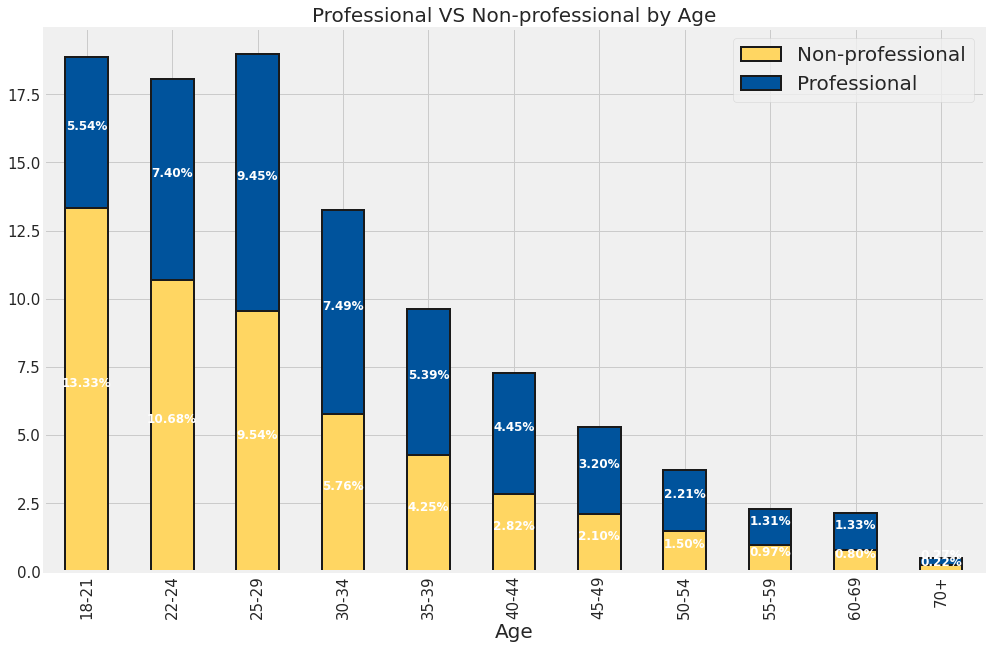

In [12]:
age = 100 * pd.crosstab(response['Age'], response['professional'])/len(response) # Convert count into percentage

# barplot
ax_1 = age.plot.bar(stacked = True, color = {'Professional' : '#00539C', 'Non-professional' :'#FFD662'}, figsize = (15,10),
                   linewidth = 2, edgecolor = 'k') ##변경:color

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.2f}%".format(height),
              ha='center', 
              va='bottom',
              color='w', ##변경
              fontweight='bold',##변경
             fontsize = 12) ##변경 
plt.xlabel('Age', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Professional VS Non-professional by Age', fontsize =20)
plt.legend(fontsize = 20)
plt.show()

It is obvious that the most professional respondants are distributed in both 25-29 and 30-34 age group while non-professionals are much younger. 

Let's see how different ages would be distributed by sub-category. (DS,DA, DE, Other)

In [13]:
# Professional vs Non-professional 
cond_pro = (response['professional'] == 'Professional')
pro = response[cond_pro]
nonpro = response[-cond_pro]

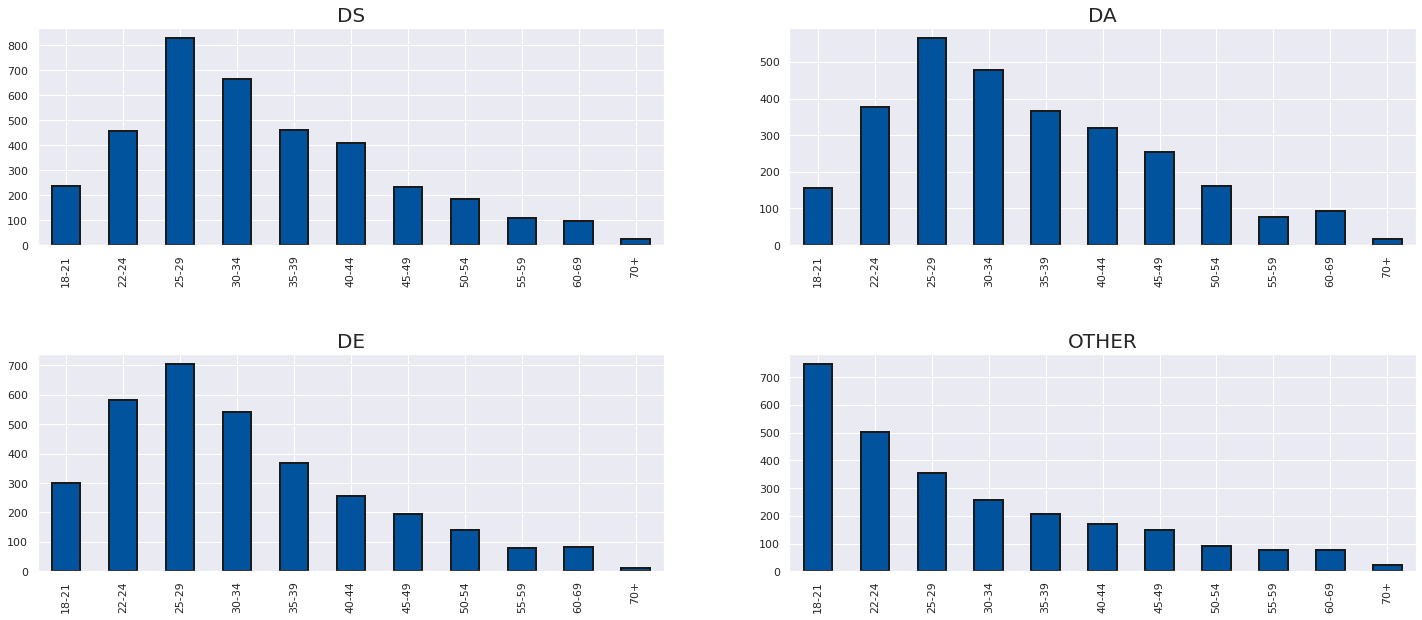

In [14]:
import itertools
plt.subplots(figsize = (22,10))
age_pro = pd.crosstab(pro['Age'], pro['RegroupJobTitle'])
# age_nonpro = pd.crosstab(nonpro['Age'], nonpro['RegroupJobTitle'])
category = ['DS','DA','DE','OTHER']
length = len(category)

sns.set_theme(style="darkgrid")

for i, j in itertools.zip_longest(category, range(length)):
    plt.subplot( (length/2), 2, j+1) # nrows, ncols, index
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

    age_pro[i].plot.bar(color = '#00539C', linewidth = 2, edgecolor = 'k') ##변경:color
#     age_nonpro[i].plot.bar(color = '#D4C8BE')
    plt.title(i, size = 20)
    plt.xlabel('')
plt.show()

## Q2. Gender

In [15]:
# Group other three gender types as 'others'
other_gender = ['Nonbinary', 'Prefer not to say', 'Prefer to self-describe']
response['Gender'] = response['Gender'].map(lambda x:'Others' if x in other_gender else x)
response['Gender'].value_counts()

# Professional vs Non-professional 
cond_pro = (response['professional'] == 'Professional')
pro = response[cond_pro]
nonpro = response[-cond_pro]

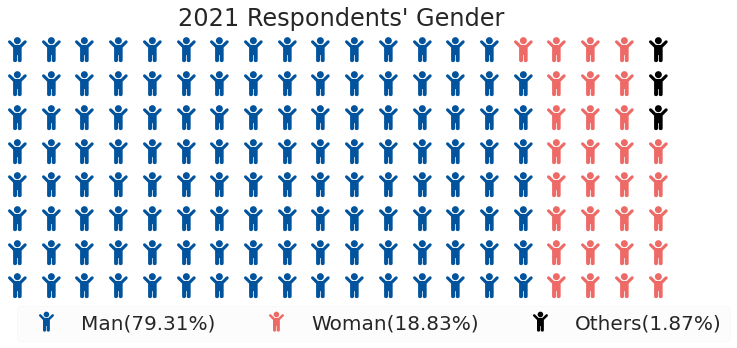

In [16]:
gender = response['Gender'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=8,
    columns=20,
    values=gender,
    colors=("#00539C", "#ed6a66", 'black'), ##변경:color
    title={'label': "2021 Respondents' Gender", 
           'loc': 'center',
          'fontdict': {
            'fontsize': 24
            }
          },
    legend={'labels': ["{}({:.2%})".format(a, b) for a, b in zip(gender.index, gender/len(response)) ],
            'loc': 'upper left',
            'bbox_to_anchor': (0, 0),
            'ncol': len(gender),
            'framealpha': 0.1,
            'fontsize': 20},

    font_size=25, 
    icons = 'child',
    icon_style = 'solid',
    figsize=(12, 5),  
    icon_legend=True
)

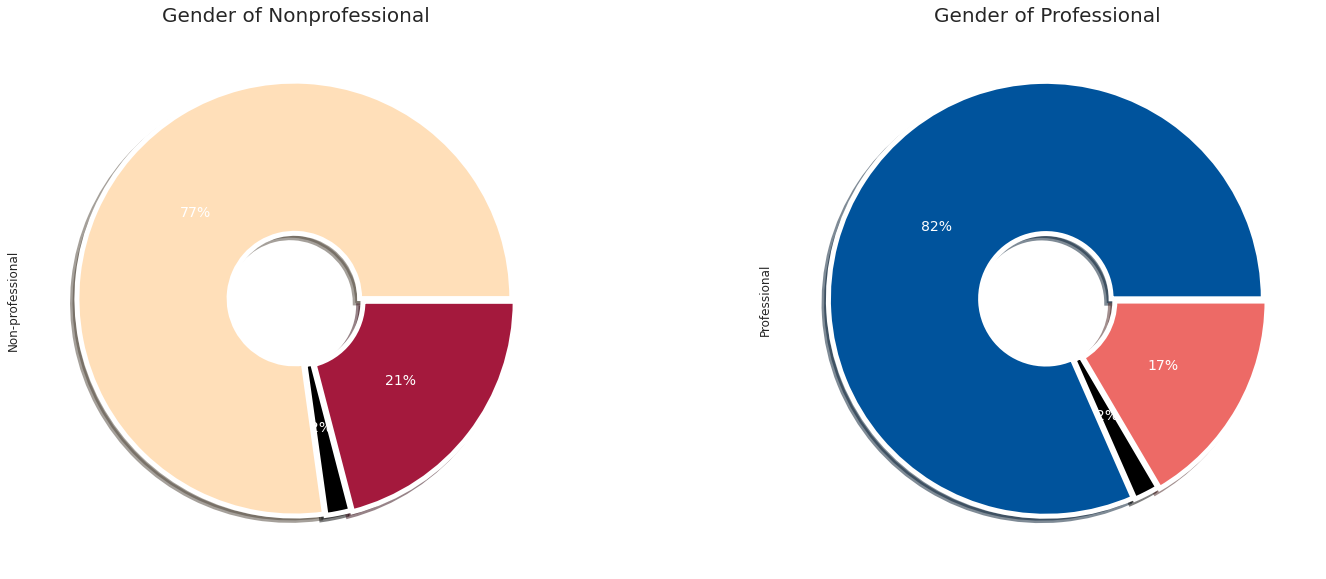

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
explode = [0.01, 0, 0.01]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# crosstab
gender = pd.crosstab(response['Gender'], response['professional'])

# Non-professional
gender['Non-professional'].plot.pie(autopct='%.0f%%', colors=("#FFDFB9", "black", "#A4193D"), ##변경:colors
                                    explode=explode, wedgeprops=wedgeprops, 
                                    textprops={'fontsize': 14, 'color' :'w'}, ax=ax[0], shadow = True) ##변경:text color
# Professional
gender['Professional'].plot.pie(autopct='%.0f%%', colors=("#00539C", "black", "#ed6a66"), ##변경:colors
                                explode=explode, wedgeprops=wedgeprops, 
                                textprops={'fontsize': 14, 'color' :'w'}, ax=ax[1], shadow = True)
ax[0].set_title('Gender of Nonprofessional', size=20)
ax[1].set_title('Gender of Professional', size=20)
plt.show()

In general, **79.31% of respondants are men** while only **18.83% are women**. However, the proportion of women who has an interest in data-related job tends to get increased by 4% than the past.



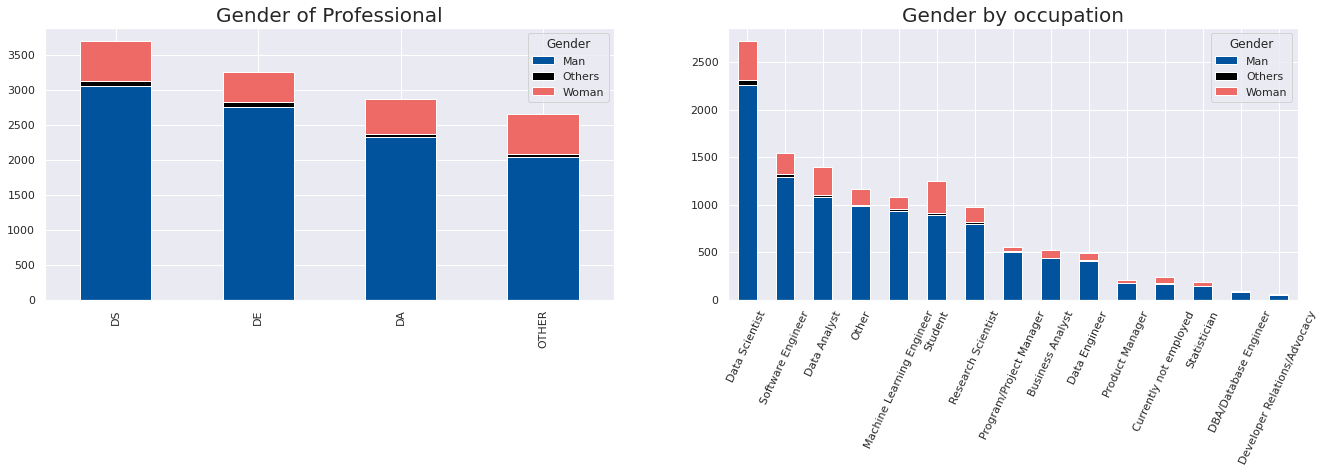

In [18]:
# Barplot
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
gender = pd.crosstab(pro['Gender'], pro['RegroupJobTitle']).T.sort_values(by='Man', ascending=False)
gender.plot.bar(stacked=True, color=("#00539C", "black", "#ed6a66"), ax=ax[0]) ##변경:colors

gender_spe = pd.crosstab(pro['Gender'], pro['JobTitle']).T.sort_values(by='Man', ascending=False)
gender_spe.plot.bar(stacked=True, color=("#00539C", "black", "#ed6a66"), ax=ax[1]) ##변경:colors

ax[0].set_title('Gender of Professional', size=20)
ax[1].set_title('Gender by occupation', size=20)

ax[0].set_xlabel('')
ax[1].set_xlabel('')

plt.xticks(rotation=65)

plt.show()

The above graph simply shows preferrable or popular jobs by each job title categories. 

It turns out that **data scientists** dominates over the others followed by both **software engineer and data analyst**. 


## Q3. Country

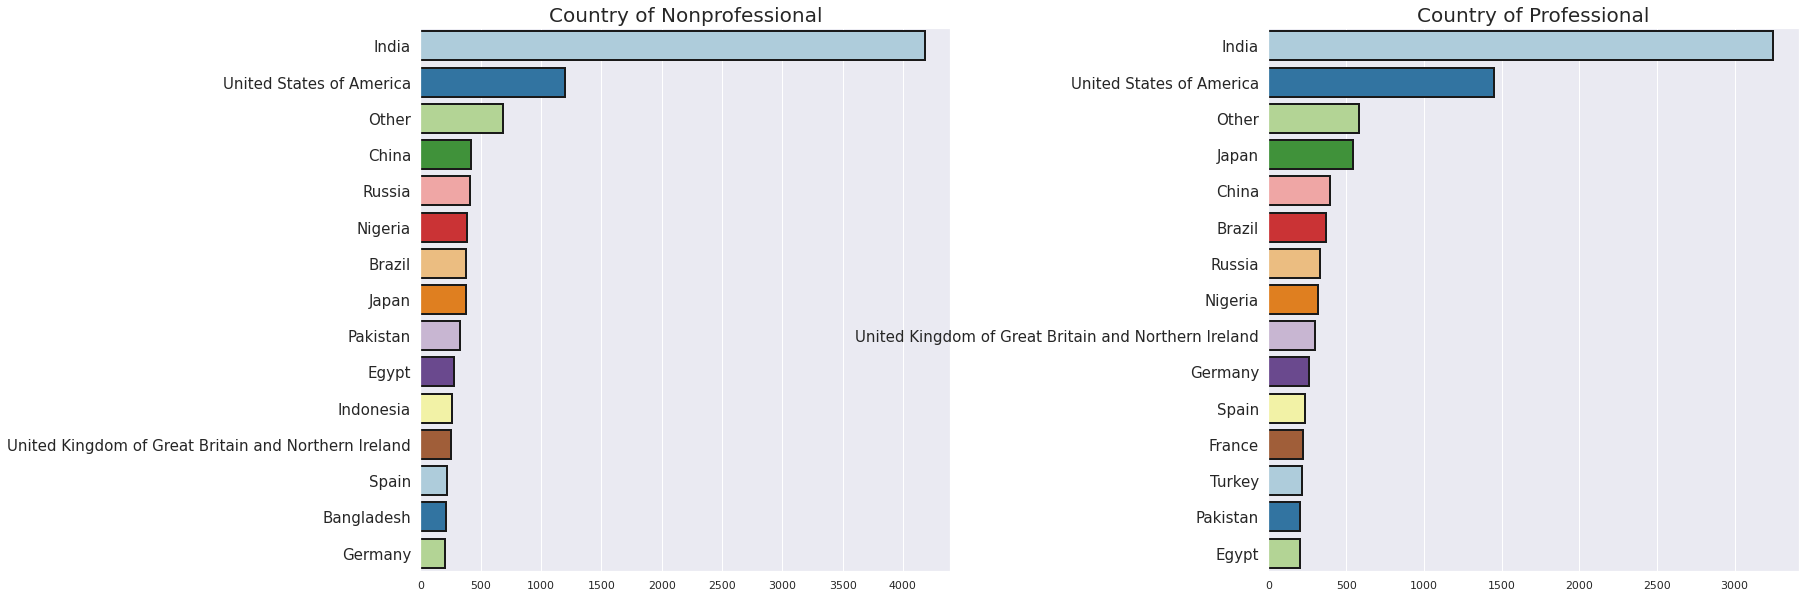

In [19]:
non_country = response[response['professional'] == 'Non-professional']['Country'].value_counts()[:15]
pro_country = response[response['professional'] == 'Professional']['Country'].value_counts()[:15]


fig, ax = plt.subplots(ncols=2, figsize=(22, 10))
sns.barplot(non_country, non_country.index, palette= 'Paired', ax=ax[0], linewidth = 2, edgecolor = 'k')
sns.barplot(pro_country, pro_country.index, palette='Paired', ax=ax[1], linewidth = 2, edgecolor = 'k')

plt.subplots_adjust(wspace=0.6, hspace=0.5)
ax[0].set_title('Country of Nonprofessional', size=20)
ax[1].set_title('Country of Professional', size=20)
ax[0].set_yticklabels(non_country.index, fontsize=15)
ax[1].set_yticklabels(pro_country.index, fontsize=15)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

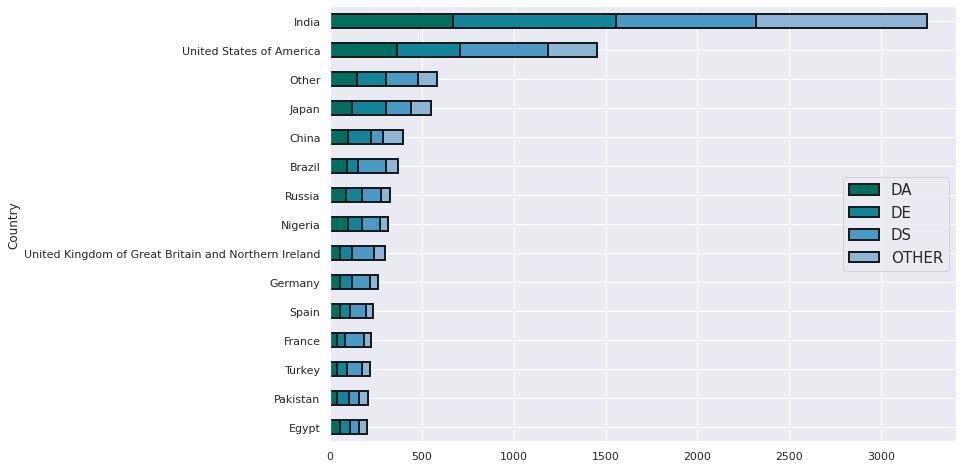

In [20]:
country_spe = pd.crosstab(pro['Country'], pro['RegroupJobTitle'])
country_spe['total'] = country_spe['DA'] + country_spe['DE'] + country_spe['DS'] + country_spe['OTHER']
country_spe = country_spe.sort_values('total', ascending=False)[:15].sort_values('total').drop('total', axis=1)

country_spe.plot.barh(stacked=True, color=sns.color_palette('PuBuGn_r'), figsize=(10, 8), linewidth = 2, edgecolor = 'k')
plt.legend(loc = 'center right', fontsize = 15)
plt.show()

Obviously, most respondants are from either India or US. 

Indonesia and Bangladesh are listed in top 15 by Non-professional respondants where they are not listed in top 15 of professional respondants' country.

As the team members are all Korean, it is unfortunate not to see South Korea in top 15

## Q4. Education

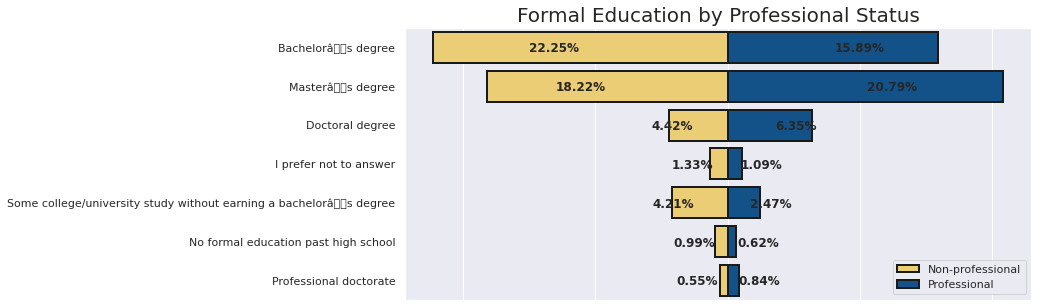

In [21]:
# Data Wrangling: Professional vs Non-professional by Education
total = response['FormalEducation'].value_counts().sum()

## Formal Education by professional as percentage over the entire respondants
### Non-professoinal
nonpro_edu = response[response['professional'] == 'Non-professional']['FormalEducation'].value_counts().to_frame()
nonpro_edu['FormalEducation'] = nonpro_edu['FormalEducation']*(-1) / total
### Professoinal
pro_edu =  response[response['professional'] == 'Professional']['FormalEducation'].value_counts() / total


# Plotting
order = response.FormalEducation.unique()
plt.figure(figsize=(10, 5))

## Non-professional
bar_plot = sns.barplot(y=nonpro_edu.index, x=nonpro_edu['FormalEducation'], order=order, color='#FFD662', ##변경:color
                       label = 'Non-professional', linewidth = 2, edgecolor = 'k')

## Professional
bar_plot = sns.barplot(y=pro_edu.index, x=pro_edu.values, order=order, color='#00539C', ##변경:color
                       label = 'Professional',linewidth = 2, edgecolor = 'k')

## Annotation
for rec in bar_plot.patches:
    height = rec.get_width()
    if height < 0:
        height_text = "{:.2%}".format( (-1) * height)
        x_loc = rec.get_x() - .02 + rec.get_width() / 2
    else:
        height_text = "{:.2%}".format(height)
        x_loc = rec.get_x() + .02 + rec.get_width() / 2
    bar_plot.text(x_loc, 
              rec.get_y() + 0.6 + rec.get_x() / 2,
              height_text,
              ha='center', 
              va='bottom',
              fontweight='bold',##변경
              fontsize = 12) ##변경 ) 


## Remove x-axis label
plt.xlabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(loc = 'lower right')
plt.title('Formal Education by Professional Status', fontsize = 20)
plt.show()

- As about 22% of Non-professional has Bachelor's Degree followed by Master's degree, most of Non-professional respondant finish up at least Bachelor's degree. 

- Unlike Non-professional respondants, professionals prefer to complete at least Master's degree

In [22]:
pd.crosstab(response[response['professional'] == 'Non-professional']['Age'],response[response['professional'] == 'Non-professional']['FormalEducation']).columns

Index(['Bachelorâs degree', 'Doctoral degree', 'I prefer not to answer',
       'Masterâs degree', 'No formal education past high school',
       'Professional doctorate',
       'Some college/university study without earning a bachelorâs degree'],
      dtype='object', name='FormalEducation')

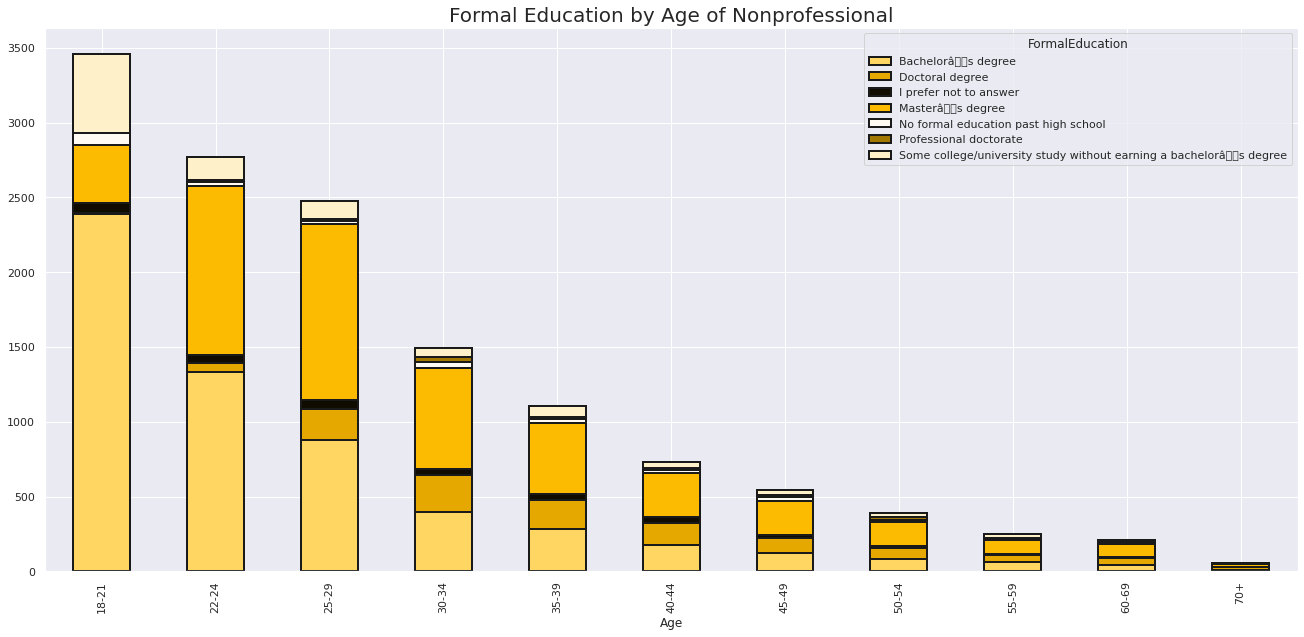

In [23]:
## 변경 : nonprofessional 그룹의 age별 education을 살펴봤는데, 나이가 들수록 점점 master degree가 늘어나더라고요!

# Data Wrangling: Non-rofessional Education by Age
total = pd.crosstab(response[response['professional'] == 'Non-professional']['Age'],response[response['professional'] == 'Non-professional']['FormalEducation'])
col_color = {'Bachelorâs degree':'#FFD662',
             'Masterâs degree':'#fcba00',
             'Doctoral degree':'#e4a800',
             'Professional doctorate':'#a37800',
             'Some college/university study without earning a bachelorâs degree':'#fef1c9',
             'No formal education past high school':'#fffbf2',
             'I prefer not to answer':'#100c00'}

total.plot.bar(figsize=(20,10), stacked=True, color=col_color, linewidth = 2, edgecolor = 'k')
plt.title('Formal Education by Age of Nonprofessional', fontsize =20)
plt.show()

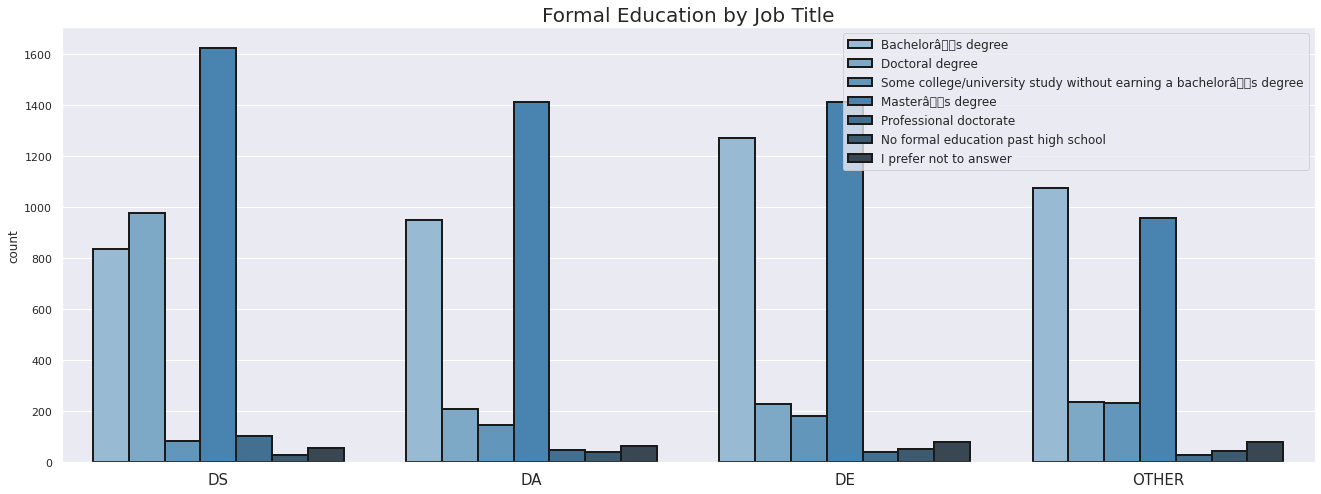

In [24]:
# FormalEducation vs JobTitle
## Plotting
plt.figure(figsize=(20, 8))
sns.countplot(x = 'RegroupJobTitle', hue='FormalEducation', data = pro,
              palette='Blues_d', order=['DS', 'DA', 'DE', 'OTHER'],
             linewidth = 2, edgecolor = 'k') ##변경:palette
plt.xticks(rotation=0, fontsize = 15)
plt.xlabel('')
plt.title('Formal Education by Job Title', fontsize =20)
plt.legend(fontsize = 12)
plt.show()

## Q5. Years to Code or Use Programming

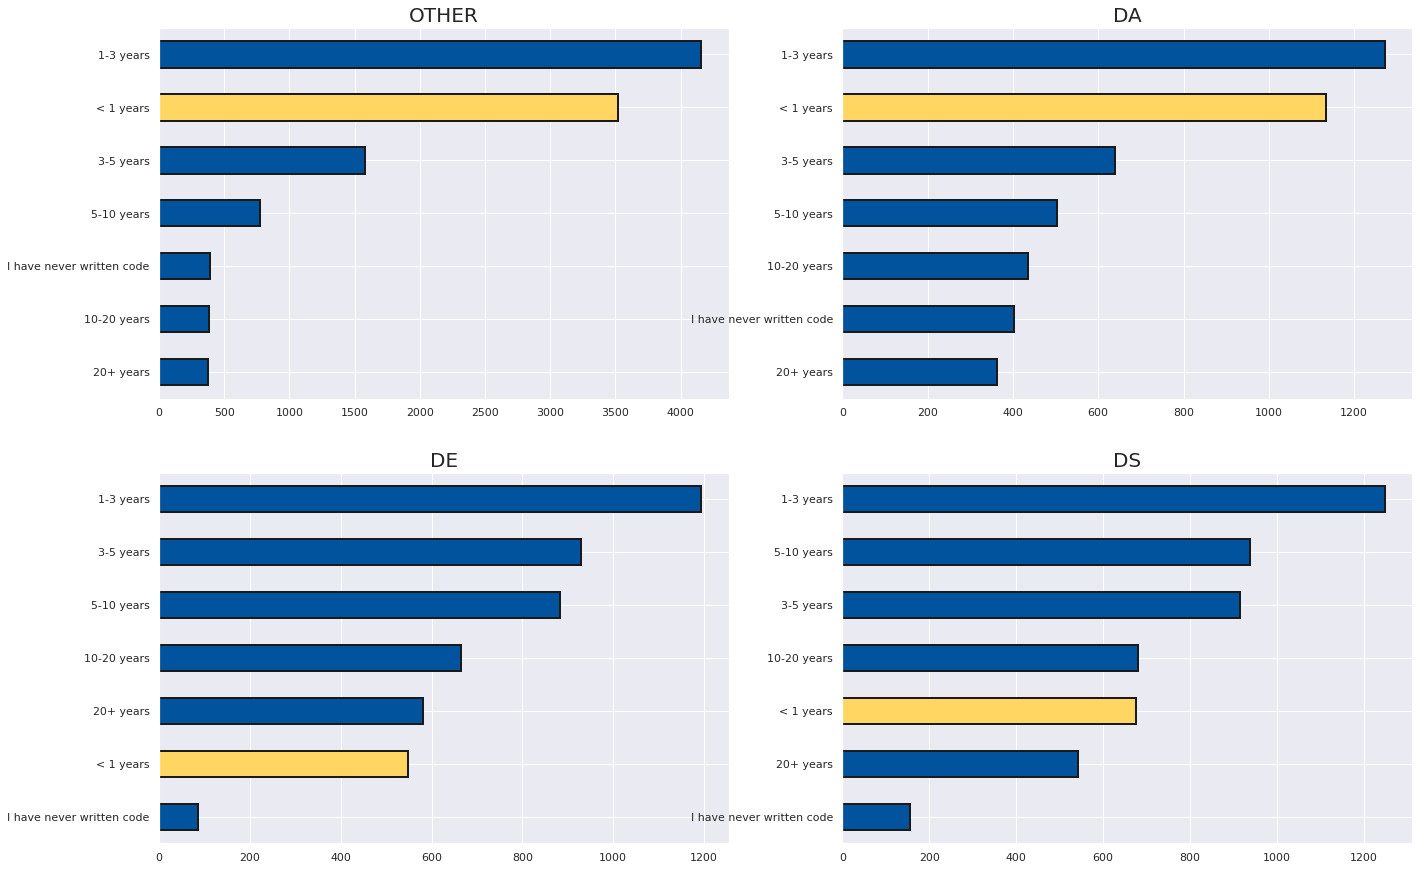

In [25]:
plt.subplots(figsize=(20,15))
job = response['RegroupJobTitle'].unique()
length = len(job)
## 변경:col_color
col_color = {'< 1 years':'#FFD662',
             'I have never written code':'#00539C',
             '1-3 years':'#00539C',
             '3-5 years':'#00539C',
             '5-10 years':'#00539C',
             '10-20 years':'#00539C',
             '20+ years':'#00539C'}

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[response['RegroupJobTitle'] == i]['YearsToCode'].value_counts(ascending=True)
    data.plot(kind='barh', color=pd.DataFrame(data).reset_index()['index'].replace(col_color),
             linewidth = 2, edgecolor = 'k')
    plt.title(i, size=20)
plt.show()

- Excluding 'OTHER', **DA** does not heavily require a programming language comparing to others.

- If you are interested in either **DE** or **DS** job, they would like to expect you to be familiar with programming languages and tend to conduct coding test before job interview.

## Q6. Programming Language to Use in regular basis

The team also explore how different languages to be prefered by job title. 

### List of Programming Language
- Python
- R
- SQL
- C
- C++
- Java
- Javascript
- Julia
- Swift
- Bash
- MATLAB
- None
- Other

In [26]:
response['Language_regular'] = response['Language_regular'].str.replace('C\++', '\++').str.replace('Javascript', 'JS')
lang = ['Python', 'R', 'SQL', 'C', '\++', 'Java', 'JS', 'Julia', 'Swift', 'Bash', 'MATLAB', 'None', 'Other']

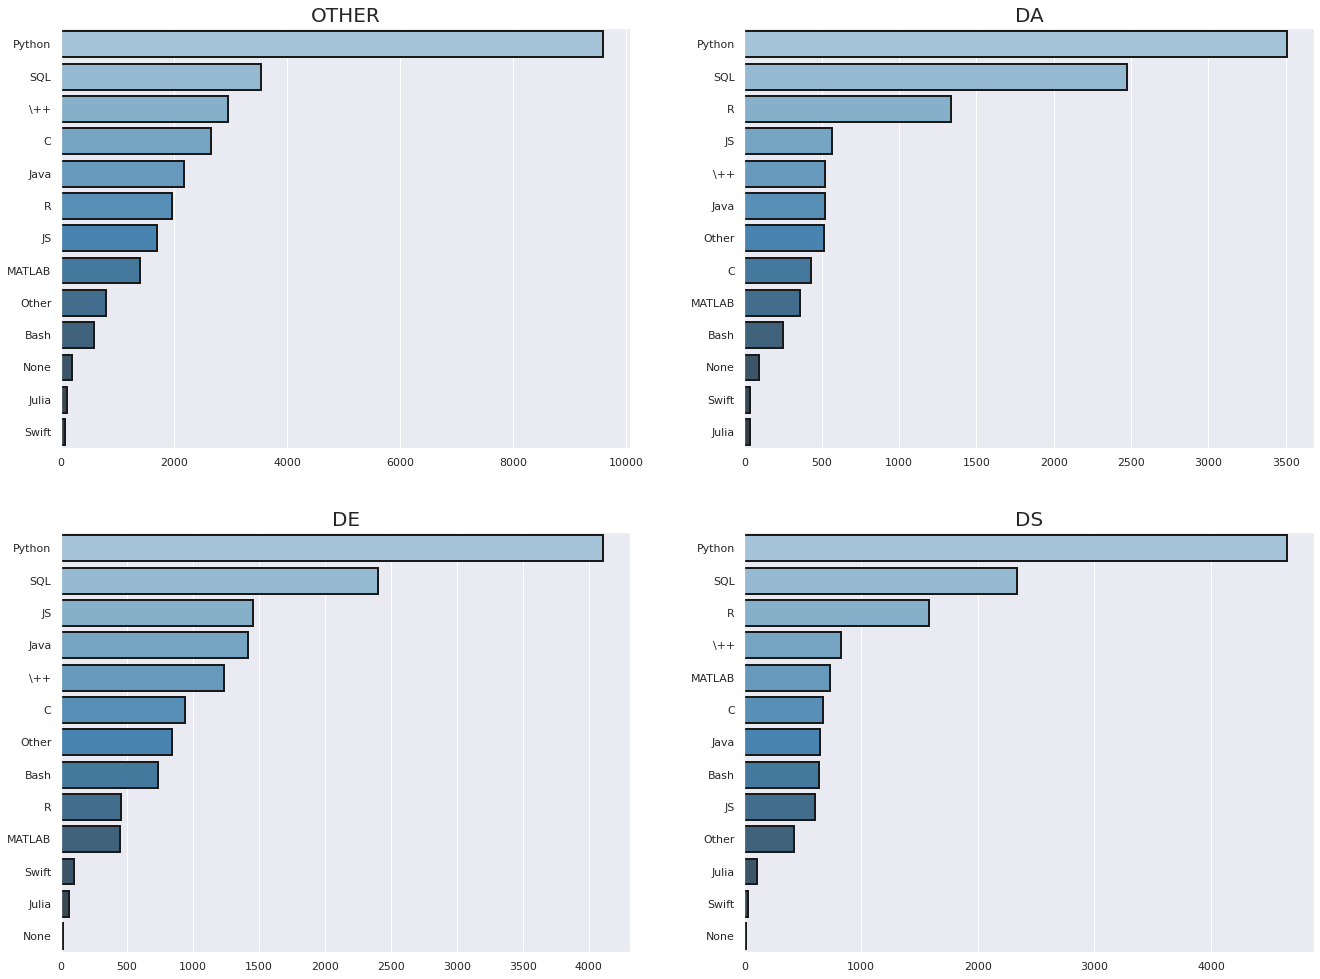

In [27]:
plt.subplots(figsize=(20,17))
job = response['RegroupJobTitle'].unique()
length = len(job)

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[response['RegroupJobTitle'] == i]  

    lan = []
    cnt = []
    for k in lang:
        lan.append(k)
        cnt.append(len(data[data['Language_regular'].str.contains(k)]))

    df = pd.DataFrame(columns=["language", 'cnt'])
    df['language'] = lan
    df['cnt'] = cnt
    df = df.sort_values(by='cnt', ascending=False)
    sns.barplot(data=df, y='language', x='cnt', palette = 'Blues_d', linewidth = 2, edgecolor = 'k') ##변경:palette
    plt.title(i, size=20)
    plt.xlabel('')
    plt.ylabel('')

- **Python and SQL** are the most popular programming language across all job title

- **R** is preferable to both **Data Science and Data Analysis** where statistics is one of necessary skills

- Those who want to be a **Data Engineer** should be familiar with **Java Script, Java and C based language**

## Q9. IDE

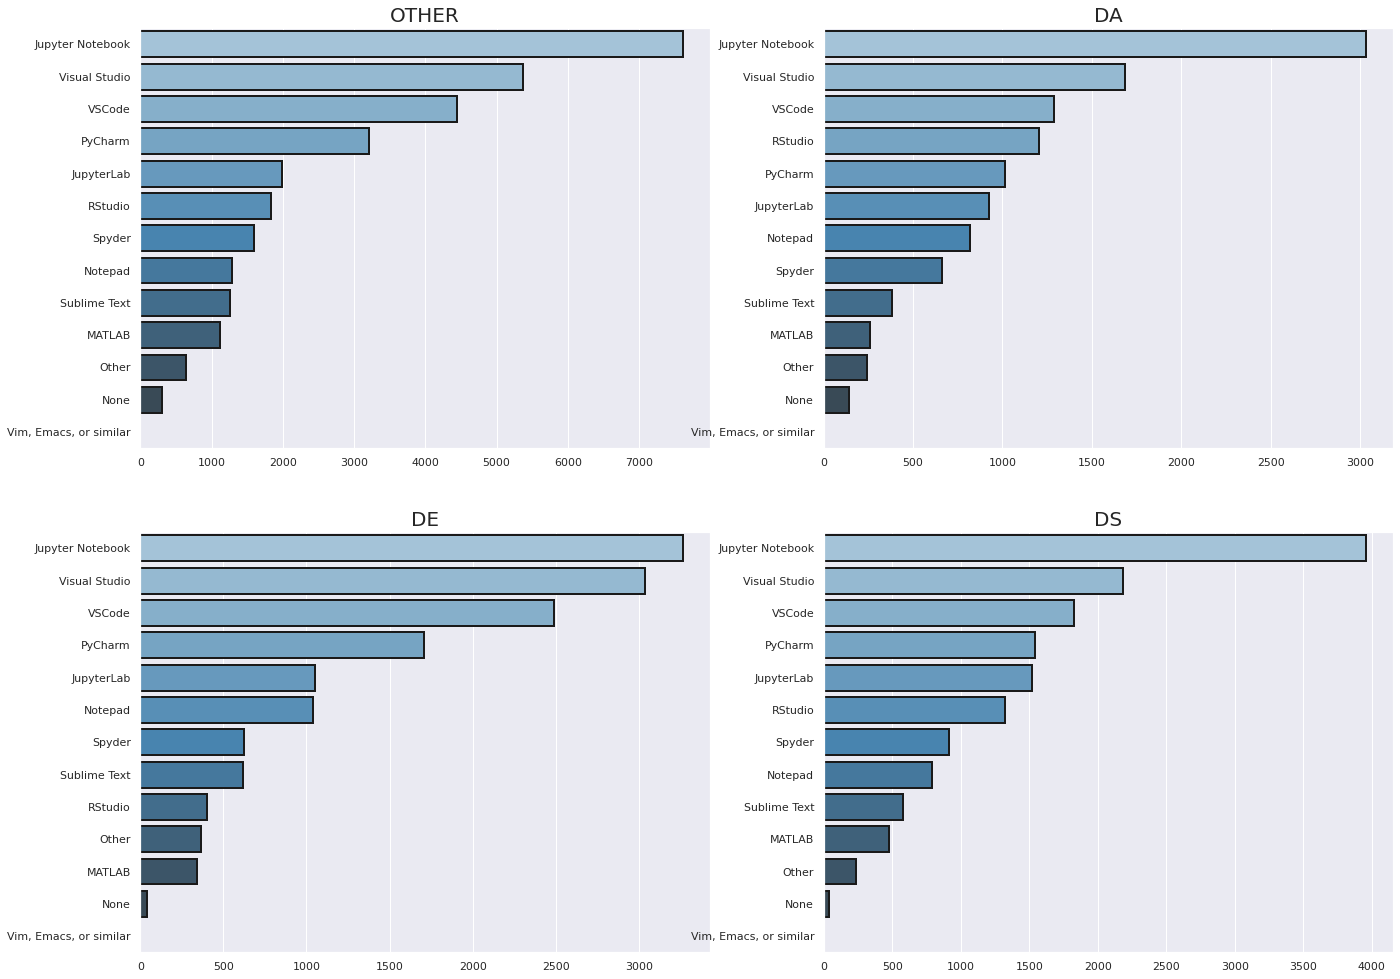

In [28]:
idle = ['JupyterLab', 'RStudio', 'Visual Studio', 'VSCode', 'PyCharm', 'Spyder', 'Notepad',
        'Sublime Text', 'Vim, Emacs, or similar', 'MATLAB', 'Jupyter Notebook', 'None', 'Other']

plt.subplots(figsize=(20,17))
job = response['RegroupJobTitle'].unique()
length = len(job)

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[response['RegroupJobTitle'] == i]  

    ide = []
    cnt = []
    for k in idle:
        ide.append(k)
        cnt.append(len(data[data['IDE'].str.contains(k)]))

    df = pd.DataFrame(columns=["ide", 'cnt'])
    df['ide'] = ide
    df['cnt'] = cnt
    df = df.sort_values(by='cnt', ascending=False)
    sns.barplot(data=df, y='ide', x='cnt', palette = 'Blues_d', linewidth = 2, edgecolor = 'k') ##변경:palette
    plt.title(i, size=20)
    plt.xlabel('')
    plt.ylabel('')

In [29]:
df = response.groupby(['RegroupJobTitle', 'JobIndustry'])['Age'].count().reset_index()
df = df[df['RegroupJobTitle'] != 'OTHER']
fig = px.treemap(df, path=[px.Constant("Job Title"), 'RegroupJobTitle', 'JobIndustry'], values='Age',
                  color='JobIndustry', title = 'Job Industry by Job Title'
                )
fig.update_traces(textinfo = 'label+percent parent')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
## fig.show()
## 삭제
fig.show(renderer="colab")

- The most actively applied industries across job titles are **Computers/Technoloy, Academics/Education and Accounting/Finance** 

- Unlike Data Analysis and Data Engineering, **Data Science** seems to focus more on **Academics/Education** than the others

- If you are interested in **Data Science** job, then it would require at least Master's degree since it has something to do with research.



# <center> Work in progress! <br>

## <center> If you like our work or have any questions, <br><br> please leave a comment and give it a like 

## <center> Thanks for your attention

# 추가

## Compensation

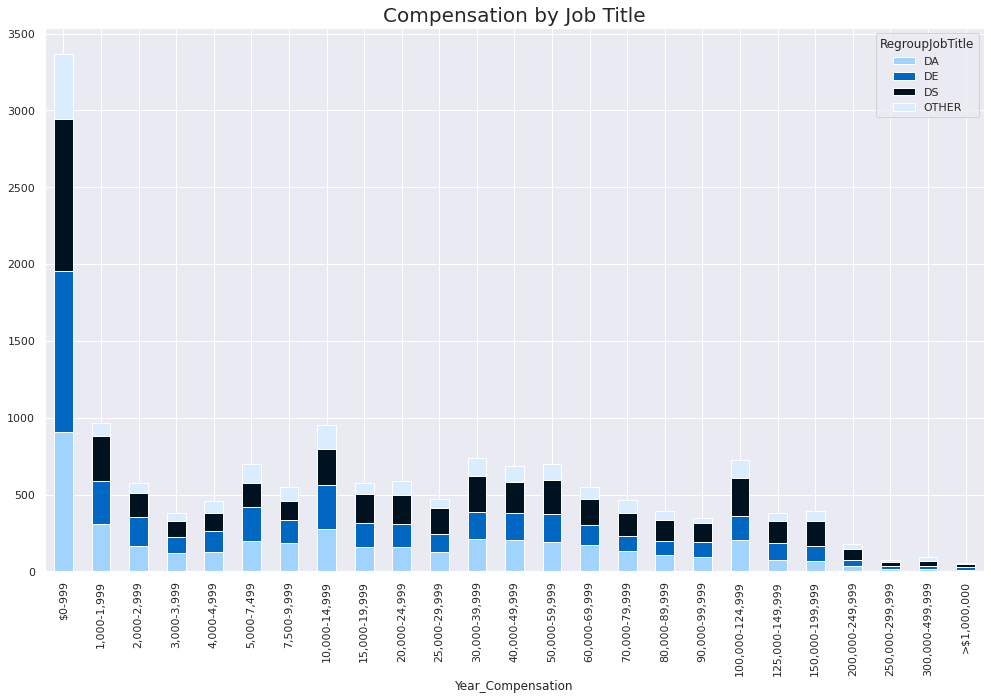

In [30]:
# bar plot에서 인덱스 정렬
index = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499',
         '7,500-9,999', '10,000-14,999', '15,000-19,999', '20,000-24,999', '25,000-29,999',
         '30,000-39,999', '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999',
         '80,000-89,999', '90,000-99,999','100,000-124,999','125,000-149,999', '150,000-199,999',
         '200,000-249,999', '250,000-299,999', '300,000-499,999', '>$1,000,000']

color = {'DA':'#a1d3ff', 'DE':'#0068c3', 'DS':'#001120', 'OTHER':'#daedfe'}

compensation = pd.crosstab(response['Year_Compensation'], response['RegroupJobTitle']).drop('', axis=0)
compensation = compensation.T[index].T ## 순서 정렬
compensation.plot.bar(stacked=True, figsize=(15,10), color=color)
plt.title('Compensation by Job Title', fontsize=20)
plt.show()

- 10만불 이상부터는 DS 비중이 높네요.

## Compensation of User Top 5 countries

In [31]:
response.Country.value_counts()[:6] # 여기서 Other 제외

India                       7434
United States of America    2650
Other                       1270
Japan                        921
China                        814
Brazil                       751
Name: Country, dtype: int64

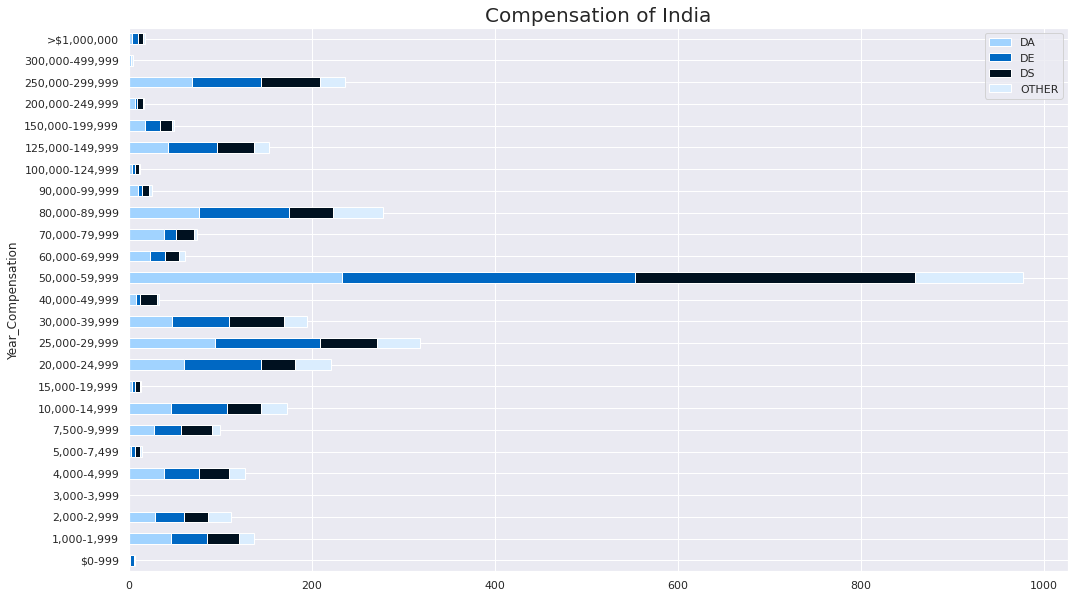

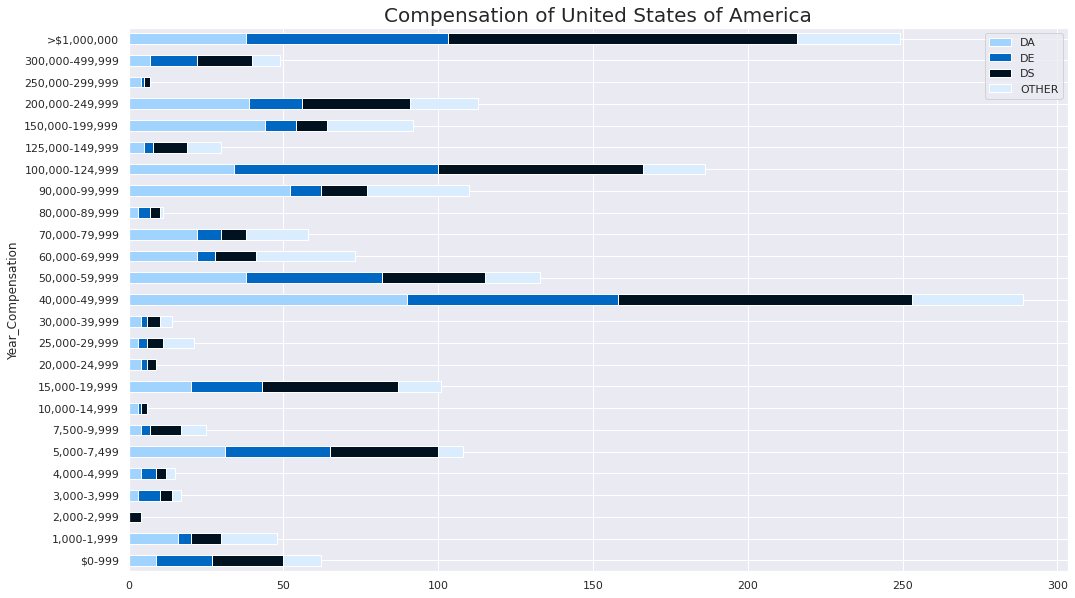

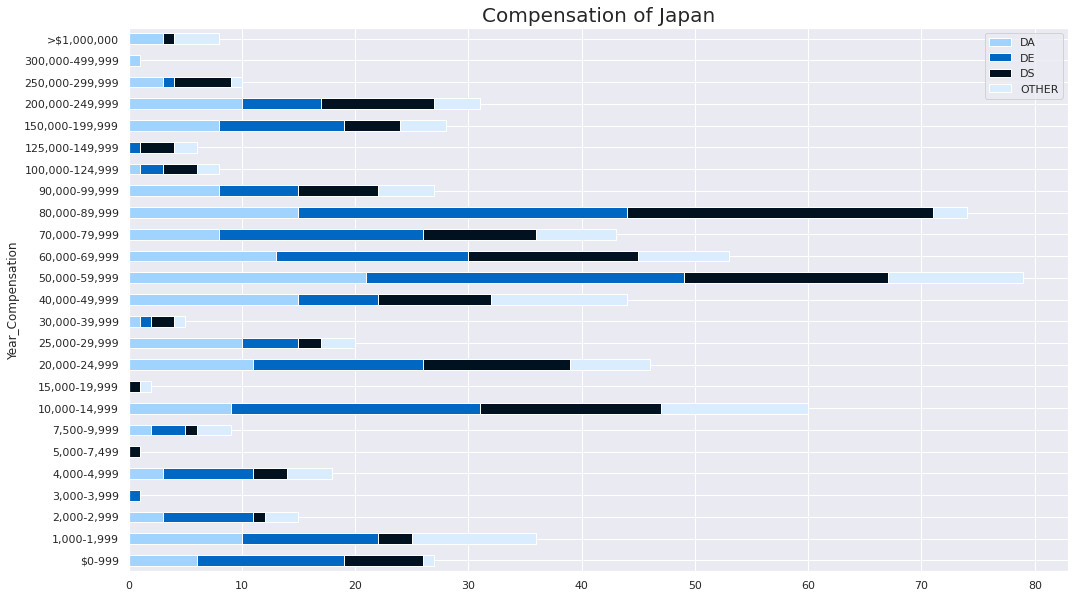

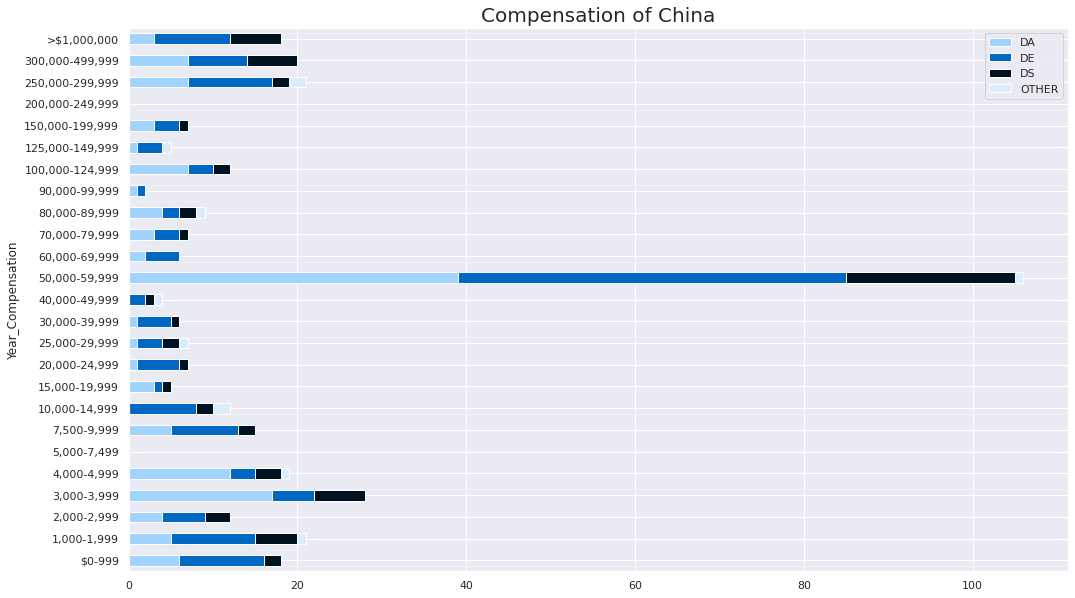

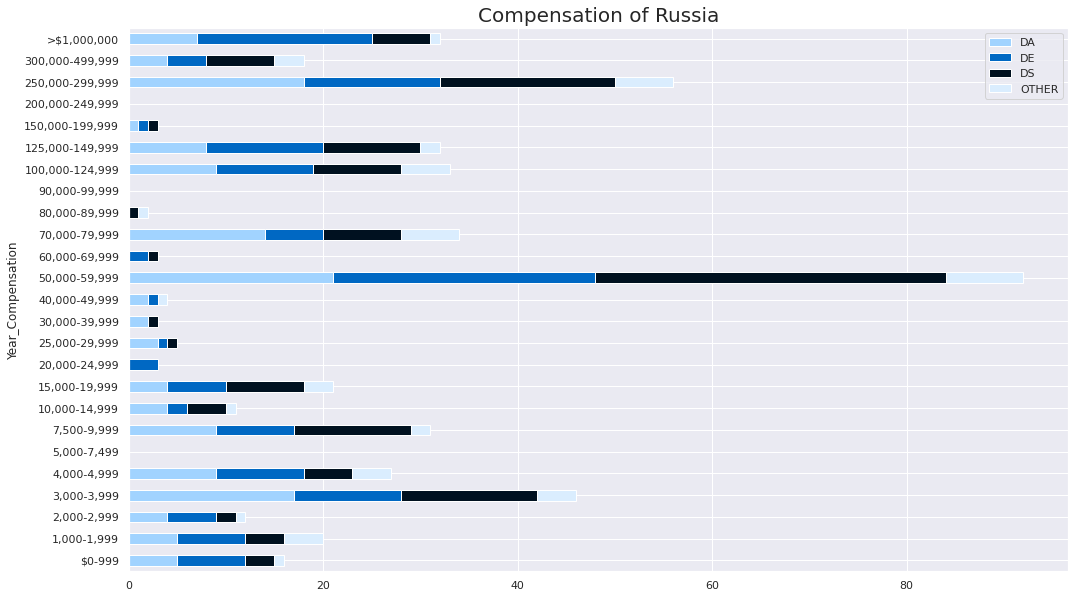

In [32]:
# 임시 데이터 프레임 생성
tmp = pd.DataFrame({'$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499',
         '7,500-9,999', '10,000-14,999', '15,000-19,999', '20,000-24,999', '25,000-29,999',
         '30,000-39,999', '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999',
         '80,000-89,999', '90,000-99,999','100,000-124,999','125,000-149,999', '150,000-199,999',
         '200,000-249,999', '250,000-299,999', '300,000-499,999', '>$1,000,000'}, columns=['Year_Compensation'])
tmp.set_index('Year_Compensation') ## 인덱스 설정
country_ls = ['India','United States of America', 'Japan', 'China', 'Russia']

for i in country_ls:
  compensation = pd.crosstab(response[response['Country'] == i]['Year_Compensation'], response[response['Country'] == i]['RegroupJobTitle']).drop('', axis=0)
  compensation = tmp.merge(compensation, how='left', on='Year_Compensation', left_index=True, right_index=True) ## 임시 데이터프레임과 병합
  compensation = compensation.set_index('Year_Compensation')
  compensation = compensation.T[index].T ## 순서 정렬
  compensation.plot.barh(stacked=True, figsize=(15,10), color=color)
  plt.title('Compensation of '+i, fontsize=20)

# 직군별로 주요한 특성을 살펴보며 취준생이 공부하면 좋을 툴(?) 등을 알아봅시다.

In [33]:
def make_dataframe(job, column, n=None):
  """ 직군별, 특정 컬럼에 대한 상위 n개 카운팅 데이터를 리턴하는 함수입니다."""
  
  df = response[(response['RegroupJobTitle']==job) & (response['professional']=='Professional')]

  ls = []
  for i in df[column].value_counts().index:
    if i != '' and i != 'None': ## Null 값 제거
      import re
      text = re.sub(r'\([^)]*\)', '', i) ## 괄호 속 문자 제거
      text = text.split(',')
      if text not in ls:
        ls = list(set(ls + text))

  lss = [i.strip() for i in ls] ## 공백 제거

  if column == 'IDE':
    lss.remove('Notepad++')
    lss.append('Notepad\++')
  
  data = response[response['RegroupJobTitle'] == job] 

  cnt = []
  for k in lss:
      cnt.append(len(data[data[column].str.contains(k)]))

  df1 = pd.DataFrame(columns=[column, 'cnt'])
  df1[column] = lss
  df1['cnt'] = cnt

  if n==None:
    df1 = df1.sort_values('cnt', ascending=False)
  else:
    df1 = df1.sort_values('cnt', ascending=False)[:n]
  
  return df1

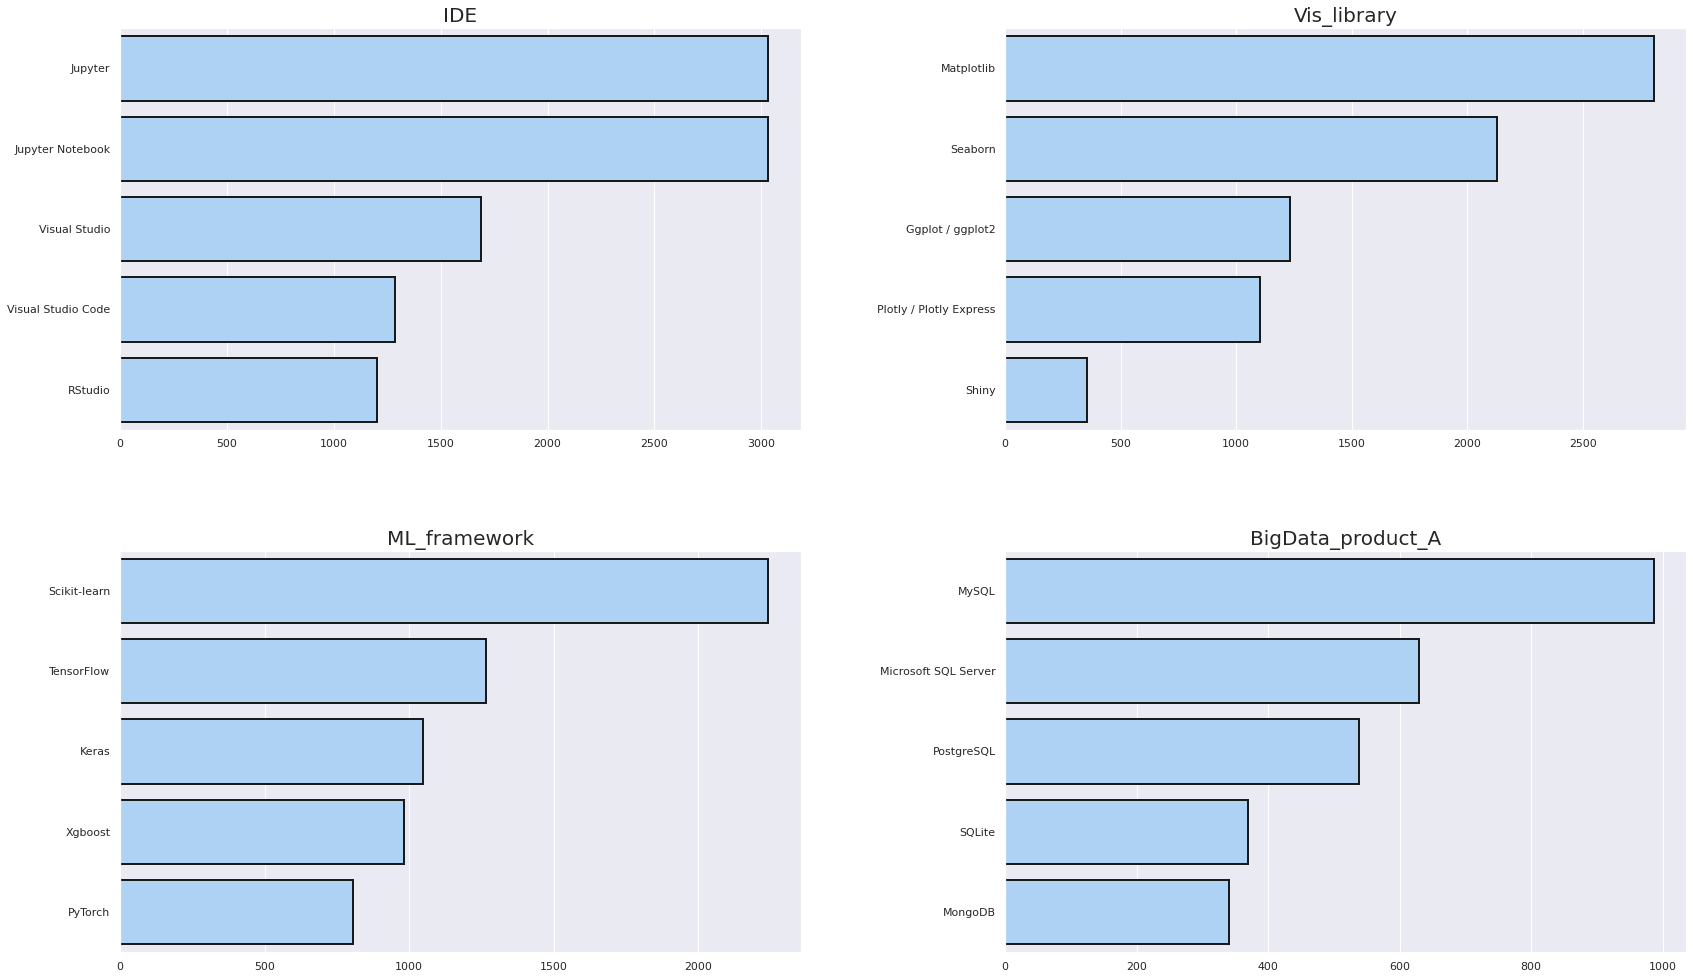

In [34]:
# DA & ['IDE', 'Vis_library', 'ML_framework', 'BigData_product_A'] 

column = ['IDE', 'Vis_library', 'ML_framework', 'BigData_product_A']
length = len(column)
plt.subplots(figsize=(25, 17))

for i, j in itertools.zip_longest(column, range(length)) :
  plt.subplot((length/2), 2, j+1)
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  df = make_dataframe('DA', i, 5)
  sns.barplot(data=df, y=i, x='cnt', color = '#a1d3ff', linewidth = 2, edgecolor = 'k') 
  plt.title(i, size=20)
  plt.xlabel('')
  plt.ylabel('')

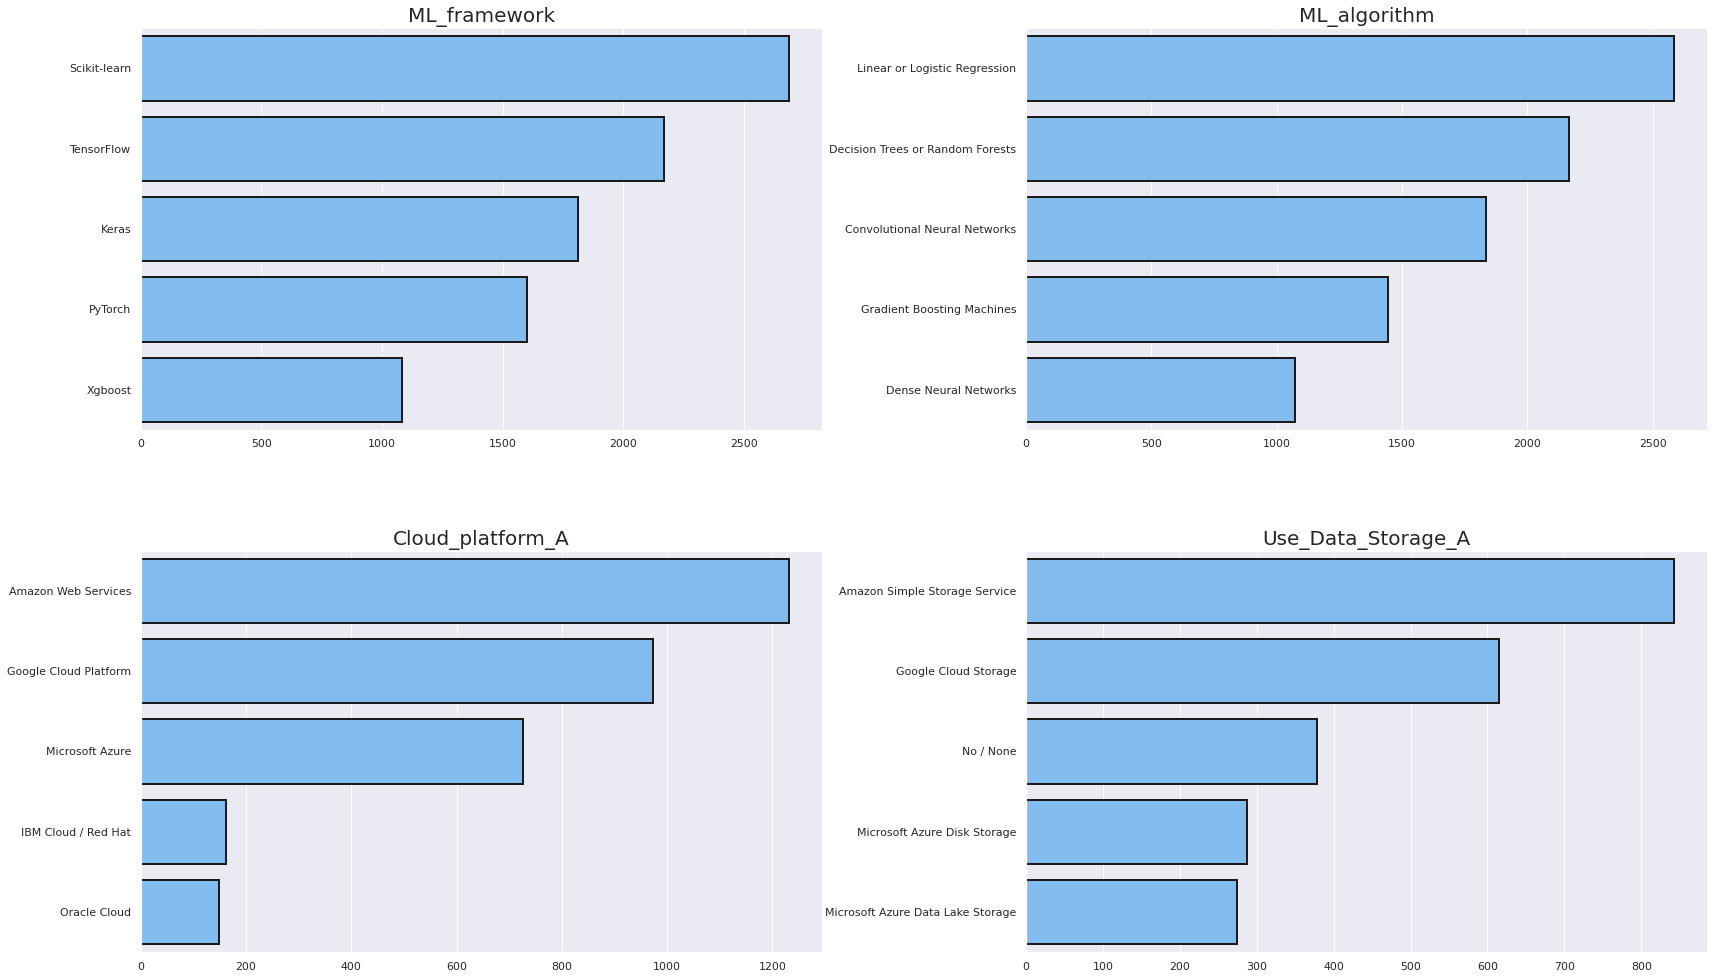

In [35]:
# DE & ['ML_framework', 'ML_algorithm', 'Cloud_platform_A', 'Use_Data_Storage_A']

column = ['ML_framework', 'ML_algorithm', 'Cloud_platform_A', 'Use_Data_Storage_A']
length = len(column)
plt.subplots(figsize=(25, 17))

for i, j in itertools.zip_longest(column, range(length)) :
  plt.subplot((length/2), 2, j+1)
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  df = make_dataframe('DE', i, 5)
  sns.barplot(data=df, y=i, x='cnt', color = '#70bcff', linewidth = 2, edgecolor = 'k') ##변경:palette
  plt.title(i, size=20)
  plt.xlabel('')
  plt.ylabel('')

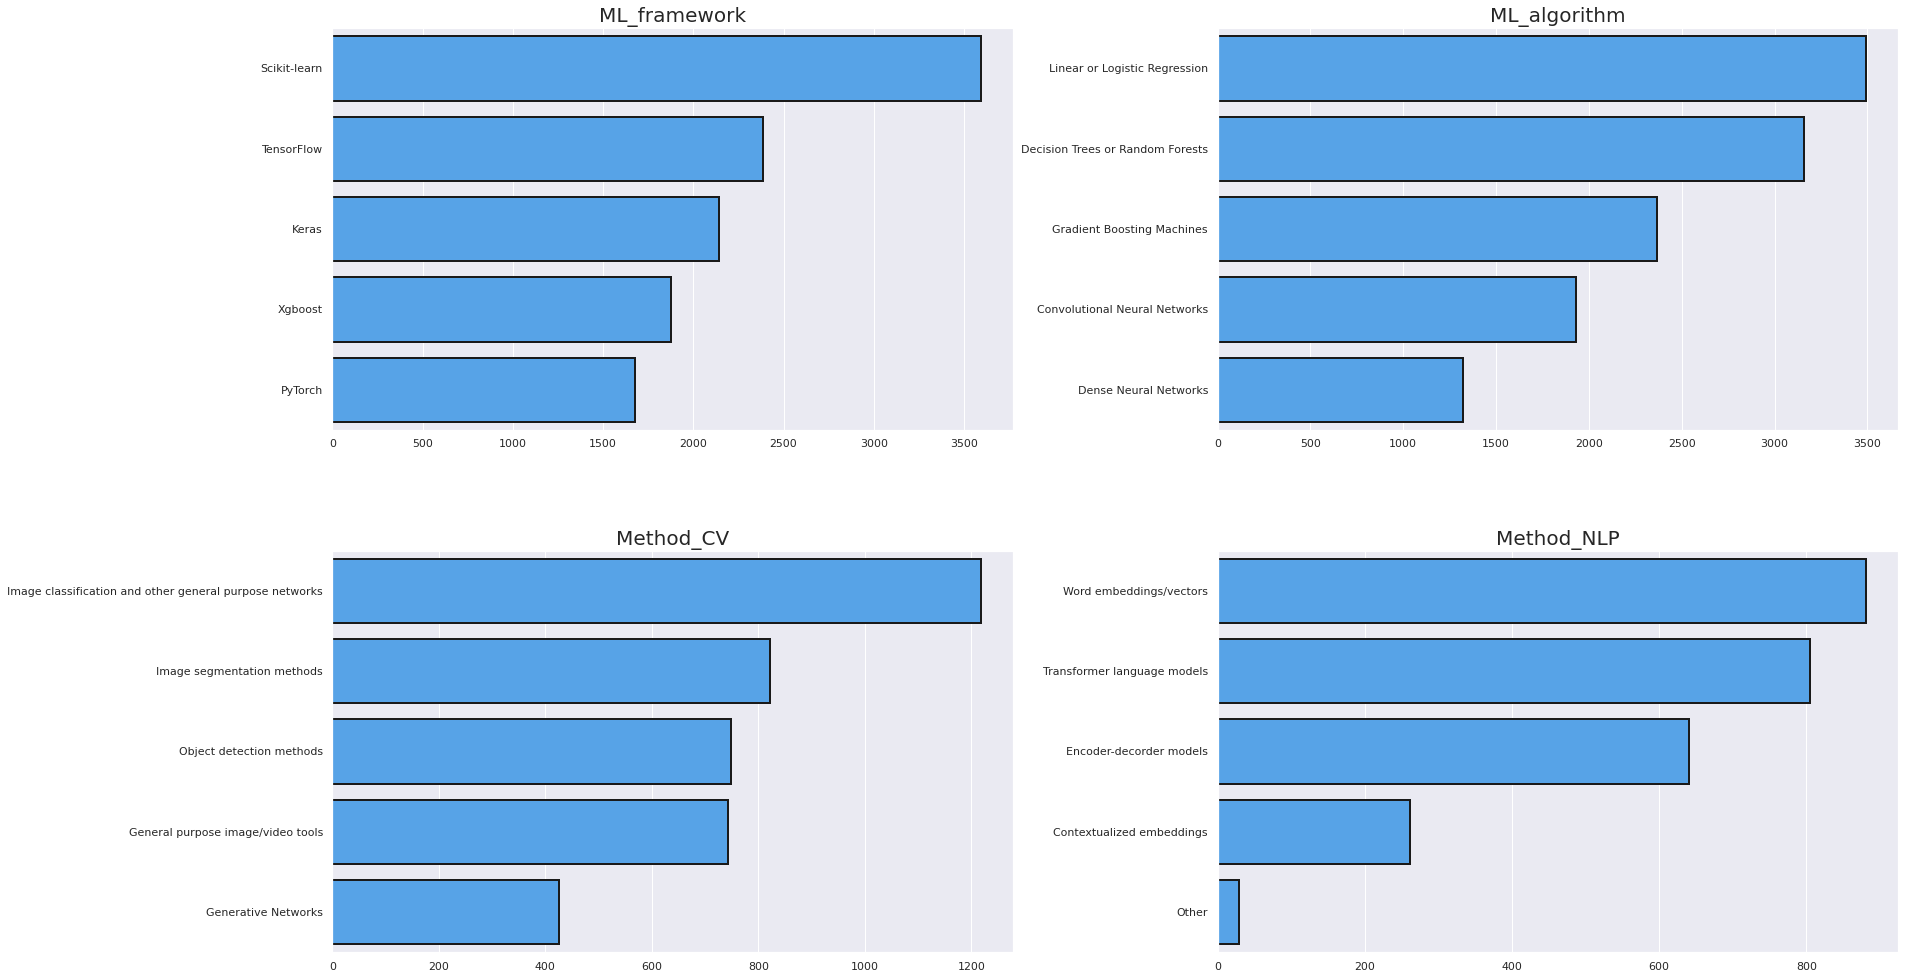

In [36]:
# DS & ['ML_framework', 'ML_algorithm' ,'Method_CV', 'Method_NLP']

column = ['ML_framework', 'ML_algorithm' ,'Method_CV', 'Method_NLP']
length = len(column)
plt.subplots(figsize=(25, 17))

for i, j in itertools.zip_longest(column, range(length)) :
  plt.subplot((length/2), 2, j+1)
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  df = make_dataframe('DS', i, 5)
  sns.barplot(data=df, y=i, x='cnt', color='#3fa5ff', linewidth = 2, edgecolor = 'k') ##변경:palette
  plt.title(i, size=20)
  plt.xlabel('')
  plt.ylabel('')

# 실무자 추천 언어 및 미디어

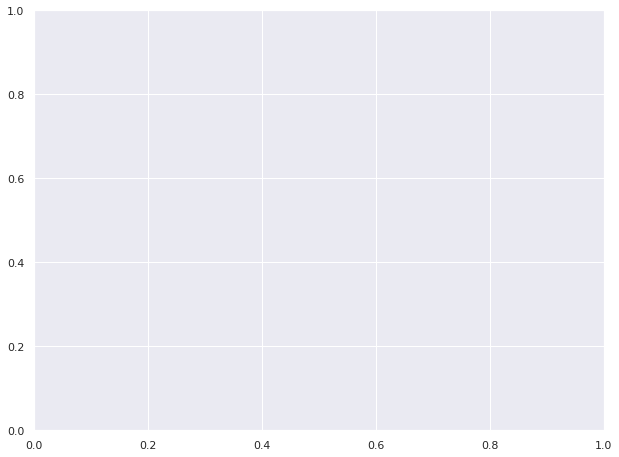

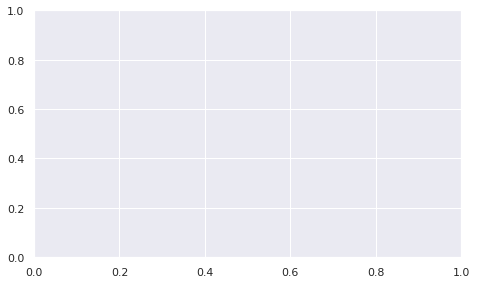

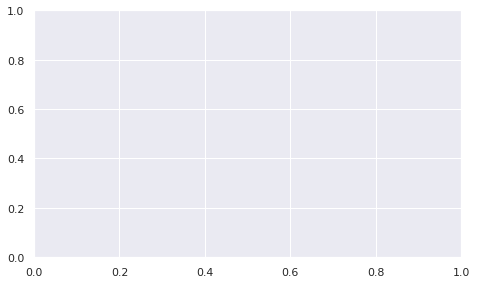

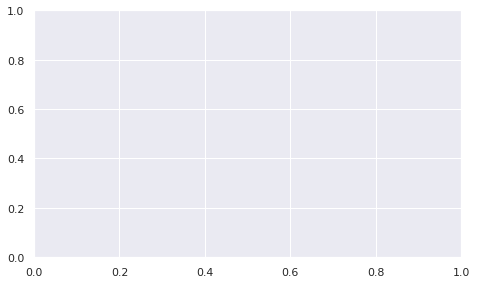

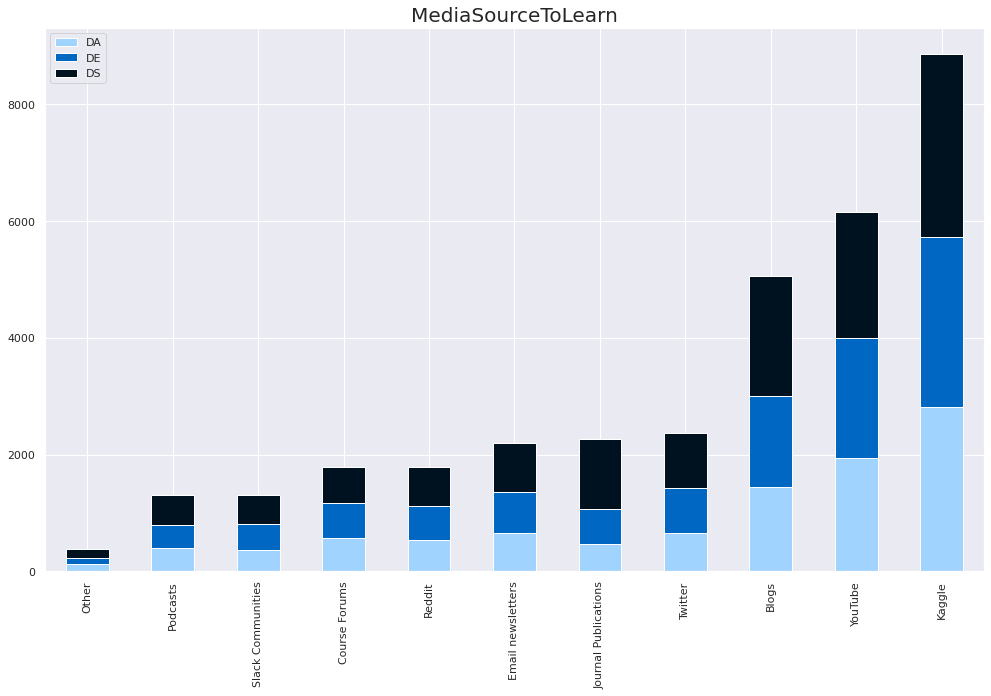

In [45]:
column = ['PublicToDeploy', 'PlatformToLear_DS', 'PrimaryTool', 'MediaSourceToLearn' ]
length = len(column)
plt.subplots(figsize=(20, 17))

for i, j in itertools.zip_longest(column, range(length)) :
  plt.subplot((length/2), 2, j+1)

  df1 = make_dataframe('DA', i)
  df2 = make_dataframe('DE', i)
  df3 = make_dataframe('DS', i)
  df1.columns = [i, 'DA']
  df2.columns = [i, 'DE']
  df3.columns = [i, 'DS']

  df = df1.merge(df2, on=i)
  df = df.merge(df3, on=i)
  df['Total'] = df['DA'] + df['DE'] + df['DS']
  df = df.sort_values('Total')
  df.drop('Total', axis=1, inplace=True)
  df.set_index(i, inplace=True)

  df.plot.bar(stacked=True, figsize=(15,10), color=color)
  plt.title(i, size=20)
  plt.xlabel('')
  plt.ylabel('')

plt.show()